# Bayesian vizualization

In [37]:
import arviz as az
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from jax import random
from numpyro import diagnostics, infer
from scipy import stats

rng_key = random.PRNGKey(0)
numpyro.set_host_device_count(4)

# Data

In [2]:
df = pd.read_csv("../data/data.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)

df["log_satellite"] = np.log(df["sat_2014"])
df["log_pm25"] = np.log(df["pm25"])
df["super_region"] -= 1

In [3]:
df.head()

,City_locality,iso3,country,super_region,super_region_name,pm25,sat_2014,coords.x1,coords.x2,optional,log_satellite,log_pm25
0,NaN,AUS,Australia,0,HighIncome,33.463801,33.314292,69.191277,34.530762,True,3.505986,3.510464
1,��_��__lhavo,PRT,Portugal,0,HighIncome,15.000000,9.867000,67.116669,36.700001,True,2.289196,2.708050
2,��_��__vila,ESP,Spain,0,HighIncome,10.000000,9.175500,19.821772,41.330269,True,2.216537,2.302585
3,AACHEN,DEU,Germany,0,HighIncome,13.000000,15.537997,1.539139,42.509693,True,2.743288,2.564949
4,AALBORG,DNK,Denmark,0,HighIncome,11.000000,9.798502,54.504269,24.406380,True,2.282230,2.397895


# Fig. 1

<AxesSubplot:xlabel='log_satellite', ylabel='log_pm25'>

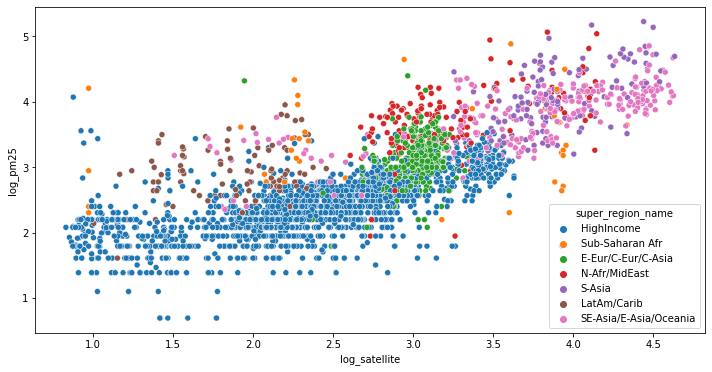

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="log_satellite", y="log_pm25", hue="super_region_name", data=df)

<AxesSubplot:xlabel='log_pm25', ylabel='Count'>

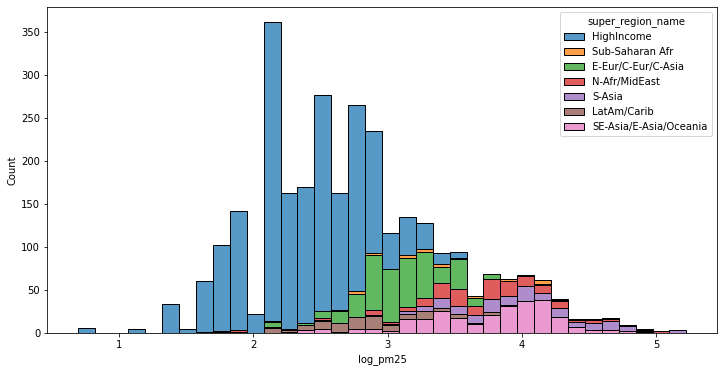

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(x="log_pm25", hue="super_region_name", data=df, multiple="stack")

# Fig. 3

In [6]:
x = jnp.array(df["log_satellite"])
y = jnp.array(df["log_pm25"])
group = jnp.array(df["super_region"])

In [7]:
def linear_regression(x, group, y=None):
    n_group = len(np.unique(group))
    w = numpyro.sample("w", dist.Normal(jnp.zeros(n_group), jnp.ones(n_group)))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10 * jnp.ones(n_group)))
    numpyro.deterministic("y_hat", w[group] * x)
    numpyro.sample("y", dist.Normal(w[group] * x, sigma[group]), obs=y)

In [8]:
rng_key, rng_key_linear = random.split(rng_key)

kernel = infer.NUTS(linear_regression)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(rng_key_linear, x, group, y)
posterior_samples = mcmc.get_samples()

/Users/ryosukenagumo/bayesian_workflow/.venv/lib/python3.9/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
sample: 100%|██████████| 1500/1500 [00:02<00:00, 700.69it/s, 7 steps of size 5.62e-01. acc. prob=0.88]


In [9]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.46      0.01      0.46      0.45      0.47   8562.28      1.00
  sigma[1]      0.46      0.03      0.46      0.41      0.50   8061.08      1.00
  sigma[2]      0.44      0.03      0.44      0.40      0.49   8379.75      1.00
  sigma[3]      0.32      0.01      0.32      0.30      0.34   7174.40      1.00
  sigma[4]      0.61      0.04      0.60      0.53      0.67   7003.64      1.00
  sigma[5]      0.48      0.02      0.48      0.45      0.52   8882.15      1.00
  sigma[6]      1.23      0.15      1.22      0.98      1.45   7115.83      1.00
      w[0]      0.97      0.00      0.97      0.97      0.98   7265.37      1.00
      w[1]      1.14      0.01      1.14      1.12      1.15  10567.35      1.00
      w[2]      1.03      0.01      1.03      1.01      1.05  10824.10      1.00
      w[3]      1.03      0.01      1.03      1.02      1.03   8625.75      1.00
      w[4]      1.48      0

In [10]:
x_test = jnp.array([
    jnp.arange((x[group == i]).min(), (x[group == i]).max(), ((x[group == i]).max() - (x[group == i]).min()) / 100)
    for i in range(7)
]).ravel()
group_test = jnp.repeat(jnp.arange(7), 100)

rng_key, rng_key_posterior = random.split(rng_key)
predictive = infer.Predictive(linear_regression, posterior_samples=posterior_samples, return_sites=["y_hat", "y"])
posterior_predictive = predictive(rng_key_posterior, x_test, group_test)

y_hpdi = diagnostics.hpdi(posterior_predictive["y_hat"])

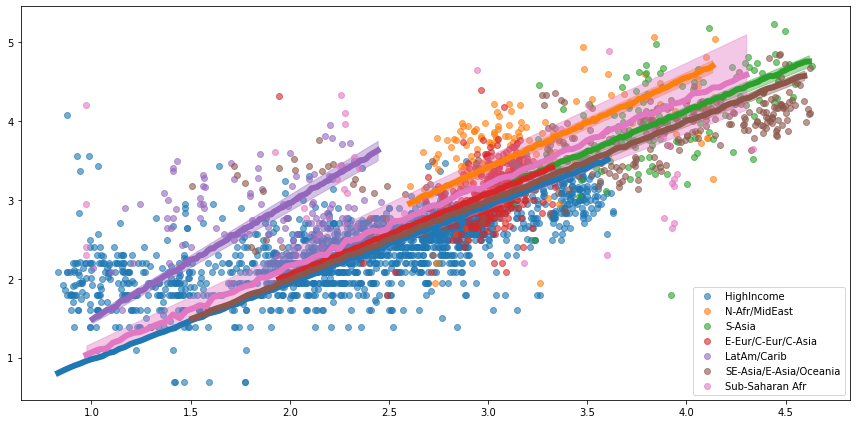

In [11]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

plt.figure(figsize=(12, 6))
for i in range(df["super_region"].nunique()):
    _tmp = df.query("super_region == @i")
    plt.scatter(_tmp["log_satellite"], _tmp["log_pm25"], color=colors[i], label=_tmp["super_region_name"].unique()[0], alpha=0.6)
    plt.plot(x_test[100 * i:100 * (i + 1)], posterior_predictive["y"][:, 100 * i:100 * (i + 1)].mean(0), color=colors[i], linewidth=6)
    plt.fill_between(x_test[100 * i:100 * (i + 1)], y_hpdi[0, 100 * i:100 * (i + 1)], y_hpdi[1, 100 * i:100 * (i + 1)], color=colors[i], alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Fig. 4

In [12]:
x = jnp.array(df["log_satellite"])
y = jnp.array(df["log_pm25"])
group = jnp.array(df["super_region"])

In [13]:
def linear_regression(x, group, y=None):
    n_group = len(np.unique(group))

    beta_0 = numpyro.sample("beta_0", dist.Normal(0, 1))
    beta_1 = numpyro.sample("beta_1", dist.Normal(1, 1))

    tau_0 = numpyro.sample("tau_0", dist.HalfNormal(1))
    beta_0k = numpyro.sample("beta_0k", dist.Normal(jnp.zeros(n_group), tau_0))

    tau_1 = numpyro.sample("tau_1", dist.HalfNormal(1))
    beta_1k = numpyro.sample("beta_1k", dist.Normal(jnp.zeros(n_group), tau_1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))

    y_hat = beta_0 + beta_0k[group] + (beta_1 + beta_1k[group]) * x
    numpyro.deterministic("y_hat", y_hat)
    numpyro.sample("y", dist.Normal(y_hat, sigma), obs=y)

In [17]:
rng_key, rng_key_posterior = random.split(rng_key)
predictive = infer.Predictive(linear_regression, num_samples=1)
posterior_predictive = predictive(rng_key_posterior, x, group)

if "y_pred" in df.columns:
    df.drop(columns=["y_pred"], inplace=True)
df["y_pred"] = posterior_predictive["y"].ravel()

<AxesSubplot:xlabel='log_satellite', ylabel='y_pred'>

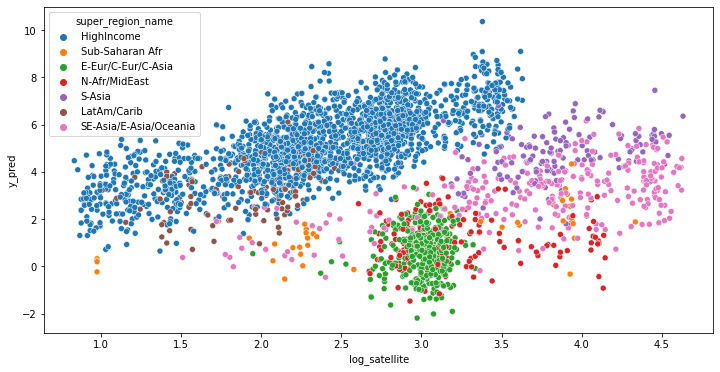

In [18]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="log_satellite", y="y_pred", hue="super_region_name", data=df)

# Fig. 6

In [22]:
def linear_regression_naive(x, group, y=None):
    w = numpyro.sample("w", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(10))
    numpyro.deterministic("y_hat", w * x)
    numpyro.sample("y", dist.Normal(w * x, sigma), obs=y)

In [20]:
def linear_regression_hierarchical(x, group, y=None):
    n_group = len(np.unique(group))

    beta_0 = numpyro.sample("beta_0", dist.Normal(0, 1))
    beta_1 = numpyro.sample("beta_1", dist.Normal(1, 1))

    tau_0 = numpyro.sample("tau_0", dist.HalfNormal(1))
    beta_0k = numpyro.sample("beta_0k", dist.Normal(jnp.zeros(n_group), tau_0))

    tau_1 = numpyro.sample("tau_1", dist.HalfNormal(1))
    beta_1k = numpyro.sample("beta_1k", dist.Normal(jnp.zeros(n_group), tau_1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))

    y_hat = beta_0 + beta_0k[group] + (beta_1 + beta_1k[group]) * x
    numpyro.deterministic("y_hat", y_hat)
    numpyro.sample("y", dist.Normal(y_hat, sigma), obs=y)

## 6.1 simple

In [53]:
rng_key, rng_key_linear = random.split(rng_key)

kernel = infer.NUTS(linear_regression_naive)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(rng_key_linear, x, group, y)
posterior_samples = mcmc.get_samples()

rng_key, rng_key_posterior = random.split(rng_key)
predictive = infer.Predictive(linear_regression_naive, posterior_samples=posterior_samples)
posterior_predictive_simple = predictive(rng_key_posterior, x, group)

numpyro_data_simple = az.from_numpyro(mcmc, posterior_predictive=posterior_predictive)

/Users/ryosukenagumo/bayesian_workflow/.venv/lib/python3.9/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
sample: 100%|██████████| 1500/1500 [00:01<00:00, 759.38it/s, 3 steps of size 5.93e-01. acc. prob=0.91]


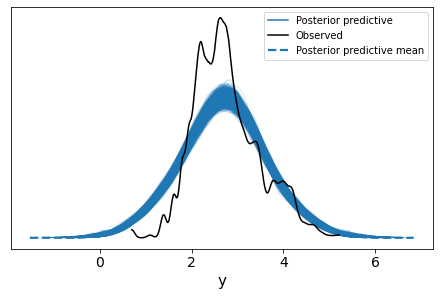

In [44]:
az.plot_ppc(numpyro_data_simple)
plt.legend(loc="upper right")
plt.show()

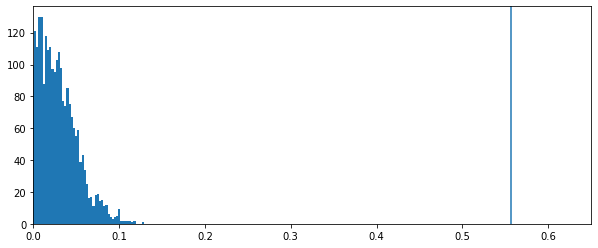

In [54]:
plt.figure(figsize=(10, 4))
plt.hist(stats.skew(posterior_predictive_simple["y"], axis=1), bins=100)
plt.axvline(stats.skew(y))
plt.xlim(0, 0.65)
plt.show()

## 6.2 hierarchical

In [55]:
rng_key, rng_key_linear = random.split(rng_key)

kernel = infer.NUTS(linear_regression_hierarchical)
mcmc = infer.MCMC(kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(rng_key_linear, x, group, y)
posterior_samples = mcmc.get_samples()

rng_key, rng_key_posterior = random.split(rng_key)
predictive = infer.Predictive(linear_regression_hierarchical, posterior_samples=posterior_samples)
posterior_predictive_hierarchical = predictive(rng_key_posterior, x, group)

numpyro_data_hierarchical = az.from_numpyro(mcmc, posterior_predictive=posterior_predictive)

/Users/ryosukenagumo/bayesian_workflow/.venv/lib/python3.9/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'
sample: 100%|██████████| 1500/1500 [00:32<00:00, 46.59it/s, 127 steps of size 1.30e-02. acc. prob=0.92]


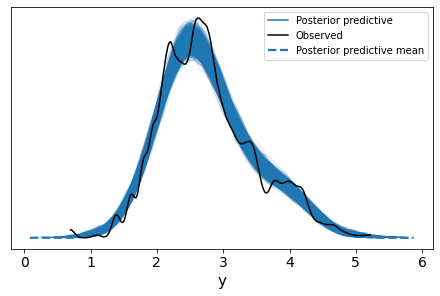

In [56]:


az.plot_ppc(numpyro_data_hierarchical)
plt.legend(loc="upper right")
plt.show()

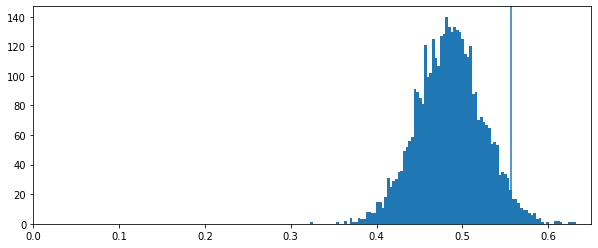

In [57]:
plt.figure(figsize=(10, 4))
plt.hist(stats.skew(posterior_predictive_hierarchical["y"], axis=1), bins=100)
plt.axvline(stats.skew(y))
plt.xlim(0, 0.65)
plt.show()

LOO-PIT (Leave-One-Out Probability Integral Transformation) predictive check

<AxesSubplot:>

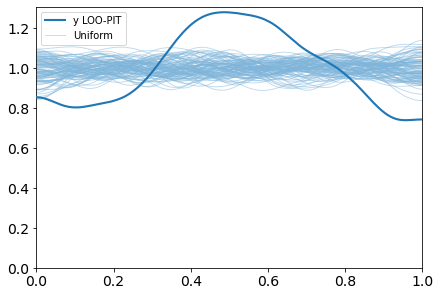

In [58]:
az.plot_loo_pit(numpyro_data_hierarchical, y="y", y_hat="y")

ELPD (expected log predictive densities) difference

/Users/ryosukenagumo/bayesian_workflow/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<AxesSubplot:title={'center':'simple - hierarchical'}, ylabel='ELPD difference'>

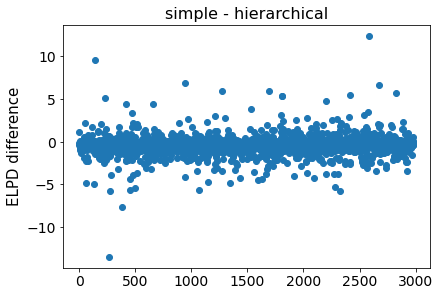

In [59]:
az.plot_elpd({"simple": numpyro_data_simple, "hierarchical": numpyro_data_hierarchical})